In [51]:
# IMPORTS #
import numpy as np
import matplotlib.pyplot as plt

In [62]:
# CONSTANTS #

IMAGE_X = 300
IMAGE_Y = 300

GAUSSIAN_X = 48
GAUSSIAN_Y = 48

SCALE_FACTOR = 8

LABEL_X = IMAGE_X // SCALE_FACTOR
LABEL_Y = IMAGE_Y // SCALE_FACTOR

# Range for Random Gen
MIN_NUM_GAUSSIANS = 2
MAX_NUM_GAUSSIANS = 5

MIN_STD_X = 7
MAX_STD_X = 12

MIN_STD_Y = 7
MAX_STD_Y = 12

MIN_THETA = 0
MAX_THETA = np.pi

MIN_INTENSITY = 0.5
MAX_INTENSITY = 1


In [69]:
# Generate Gaussian Functions
def img_gen(VERBOSE: bool = False) -> tuple:

    img = np.zeros(shape=(IMAGE_Y, IMAGE_X))
    label = np.zeros(shape=(LABEL_Y, LABEL_X))

    num_gaussians = np.random.randint(low=MIN_NUM_GAUSSIANS, high=MAX_NUM_GAUSSIANS)
    
    for gaussian in range(num_gaussians):

        # Randomize params
        center_x = np.random.randint(low=0 + GAUSSIAN_X // 2, high=IMAGE_X - GAUSSIAN_X // 2)
        center_y = np.random.randint(low=0 + GAUSSIAN_Y // 2, high=IMAGE_Y - GAUSSIAN_Y // 2)

        std_x = np.random.randint(low=MIN_STD_X, high=MAX_STD_X)
        std_y = np.random.randint(low=MIN_STD_Y, high=MAX_STD_Y)
        theta = np.random.randint(low=MIN_THETA, high=MAX_THETA)
        
        intensity = np.random.randint(low=MIN_INTENSITY, high=MAX_INTENSITY)
        
        # Generate Gaussian
        gaussian = gaussian_gen(center_x, center_y, std_x, std_y, theta)

        # Add Gaussian to img
        img += gaussian
        
        label_x = center_x // SCALE_FACTOR
        label_y = center_y // SCALE_FACTOR

        label[label_y, label_x] = 1

    # DEBUG
    if VERBOSE:
        print(f"[Image Shape]: {str(img.shape)}")
        print(f"[Label Shape]: {str(label.shape)}")
        print(f"[Target Gaussians #]: {str(num_gaussians)}")

    return (img, label)

def gaussian_gen(center_x, center_y, std_x, std_y, theta):
    X = np.arange(0, IMAGE_X, 1)
    Y = np.arange(0, IMAGE_Y, 1)
    X, Y = np.meshgrid(X, Y)

    cos_theta_sqrd = np.pow(np.cos(theta),2)
    sin_theta_sqrd = np.pow(np.sin(theta),2)
    sin_cos_theta = np.sin(theta) * np.cos(theta)

    std_x_sqrd = np.pow(std_x, 2)
    std_y_sqrd = np.pow(std_y, 2)

    a = (cos_theta_sqrd) / (2 * std_x_sqrd) + (sin_theta_sqrd) / (2 * std_y_sqrd)
    b = -1 * (sin_cos_theta) / (2 * std_x_sqrd) + (sin_cos_theta) / (2 * std_y_sqrd)
    c = (sin_theta_sqrd) / (2 * std_x_sqrd) + (cos_theta_sqrd) / (2 * std_y_sqrd)

    gaussian = np.exp(-(a * (X - center_x)**2 + 2*b * (X - center_x) * (Y - center_y) + c * (Y - center_y)**2))
    return gaussian

def img_shift():
    pass

def img_scale():
    pass

def img_visualization(img, label):
    
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray')
    
    plt.subplot(1, 2, 2)
    plt.imshow(label, cmap='gray')


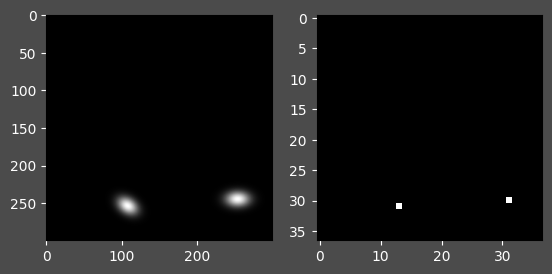

In [71]:
# Generate Training Data
img, label = img_gen()
img_visualization(img, label)


In [ ]:
# Model Architecture